<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            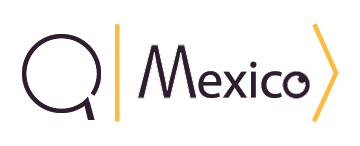
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;">Caracterización: Errores en compuertas cuánticas
</div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Bruno Ramírez</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [Errores en compuertas de un qubit](#secc1)
   1. [Error de amplitud](#secc1.1)
   2. [Caracterizando el error de amplitud en Qiskit](#secc1.2)
   3. [Error de ángulo](#secc1.3)
   4. [Caracterizando el error de ángulo en Qiskit](#secc1.4)
3. [Errores en compuertas CX](#secc2)
   1. [Error de amplitud CX](#secc2.1)
   2. [Caracterizando el error de amplitud CX en Qiskit](#secc2.2)
   3. [Error de ángulo CX](#secc2.2)
   4. [Caracterizando el error de ángulo CX en Qiskit](#secc2.2)
4. [Referencias](#secc3)

<a id="intro"></a>
# Introducción


Este es nuestro primer notebook dedicado a los errores en cómputo cuántico. Se pueden identificar errores en tres principales aspectos del cómputo cuántico: los errores e inestabilidades del sistema físico que forma un qubit, los errores generados al momento de medición y procesamiento de señales, y los errores que se generan al cambiar el estado de un qubit, es decir los errores en compuertas. Nos enfocaremos primero en este último.

El estado de un qubit se puede modificar mediante la aplicación de compuertas cuánticas. Estas compuertas toman un estado en la Esfera de Bloch y devuelven otro estado en otra ubicación en dicha esfera (a excepción de $\mathbb{I}$). Al aplicar compuertas puede suceder que el estado final no sea aquel que esperábamos. Por ejemplo, si comenzamos con el estado $\ket{0}$, puede ser que al aplicar una compuerta $X$ no nos pase al estado $\ket{1}$ sino a otro cercano a él.

Para entender la naturaleza de estos errores hay que saber cómo es que se hace la implementación física de las compuertas. En el caso de los qubits superconductores, las compuertas unitarias se hacen mediante la [emisión de pulsos de microondas](https://cahyati2d.medium.com/rabi-drive-ramsey-experiment-c14ff626e719) (en resonancia o fuera de resonancia ). Como se vió en un [notebook anterior](../02_Qiskit_Terra/03_Qiskit_Pulse.ipynb), los parámetros del pulso; su duración, su intensidad y su frecuencia, determinarán el estado final del qubit. Cualquier ajuste erróneo en estos parámetros dará lugar a una compuerta unitaria mal implementada.

En el este notebook veremos como diagnosticar los errores en compuertas cuánticas debido a la calibración de los pulsos. 


In [1]:
# Celda con los imports de Qiskit necesarios

import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error
from qiskit.providers.aer.noise import NoiseModel

from qiskit.ignis.characterization.gates import (AmpCalFitter, ampcal_1Q_circuits,
                                                 AngleCalFitter, anglecal_1Q_circuits,
                                                 AmpCalCXFitter, ampcal_cx_circuits,
                                                 AngleCalCXFitter, anglecal_cx_circuits)



<div class="alert alert-block alert-success">

**Importante:**

En la siguiente serie de notebooks estaremos usando las herramientas de Qiskit Aer para definir modelos de ruido propios. Estos modelos de ruido estarán destinados para simular el error que queramos estudiar, en cada notebook se definirán modelos de ruido distintos según el tipo de error a estudiar. Podemos evitarnos la molestia de diseñar modelos de ruido importando un modelo de ruido de un dispositivo real de IBM o incluso corriendo nuestros códigos en un dispositivo real desde la nube, como se vió en el último módulo de este taller.

</div>

In [2]:
# Creamos nuestros modelos de ruido a utilizar durante el notebook

# Modelo que genera error de amplitud a un qubit
err_unitary = np.zeros([2,2],dtype=complex) # Creamos una matriz que representa el modelo de ruido
angle_err = 0.1 # Queremos replicar este valor con AmpCalFitter
for i in range(2):
    err_unitary[i,i] = np.cos(angle_err)
    err_unitary[i,(i+1) % 2] = np.sin(angle_err)
err_unitary[0,1] *= -1.0

error = coherent_unitary_error(err_unitary) 
oneQ_amp_error = NoiseModel()
oneQ_amp_error.add_all_qubit_quantum_error(error, 'u2')

# Error de amplitud que actúa solamente cuando está activado el qubit de control
# construido para caracterizar el error en compuerta CX
cx_err_unitary = np.eye(4,dtype=complex)
cx_angle_err = 0.15 # Querremos replicar este valor con AmpCalCXFitter
for i in range(2):
    cx_err_unitary[2+i,2+i] = np.cos(cx_angle_err)
    cx_err_unitary[2+i,2+(i+1) % 2] = -1j*np.sin(cx_angle_err)

cx_error = coherent_unitary_error(cx_err_unitary)
cx_noise_model = NoiseModel()
cx_noise_model.add_nonlocal_quantum_error(cx_error, 'cx', [1,0], [0,1])

<a id="secc1"></a>
# Errores en compuertas de un qubit

Considerando que una compuerta unitaria debe poder llevar un estado a cualquier otro en la Esfera de Bloch, podemos entender una compuerta unitaria de un qubit como una rotación de un ángulo $\theta$ alrededor de un eje arbitrario $\vec{n}$. Recordando que las matrices de Pauli son las generadoras de rotaciones en cada uno de los ejes, y que $\vec{\sigma}= (\hat{\sigma}_x,\hat{\sigma}_y,\hat{\sigma}_z)$, podemos describir la compuerta como:

$$ U(\theta, \hat{n}) = e^{-i\theta \vec{n}\cdot\sigma/2}$$

Es conveniente estudiar detalladamente el comportamiento de las rotaciones con respecto a algún eje expecífico, tomemos el eje X colocando $\vec{n} = (1,0,0)$. Tenemos entonces una rotación de un ángulo $\theta$ con respecto al eje X:

$$R_X(\theta) = U(\theta, (1,0,0)) = e^{-i\theta\sigma_x/2}$$

Esto representa una rotación perfecta, algo que solo existe teóricamente. Al implementar rotaciones en qubits pueden suceder dos tipos de errores. Adelante revisamos cada uno de ellos.

<a id="secc1.1"></a>
## Error de amplitud

El error de amplitud representa una rotación con el eje bien definido, pero con un ángulo desviado. Por ejemplo, supongamos que queremos implementar una rotación de $\pi/2$ (90 grados) alrededor del eje Y, idealmente deberíamos tener 

$$Y90 = R_Y(\pi/2) = e^{-i\pi\sigma_Y/4}$$

Sin embargo, lo que sucede en realidad es que hay una desviación del ángulo de rotación, teniendo una rotación errónea

$$ Y90_{E} = R_{Y}(\pi/2 + d\theta) = e^{-i(\pi/2 + d\theta)\sigma_x/2}$$

Este error suele ser muy pequeño, pero a lo largo de múltiples aplicaciones se vuelve evidente. Se suele amplificar el error aplicando una secuencia de la compuerta

$$Y90 -- \big[Y90 -- Y90\big]^n$$

La presencia de los dobles guiones simplemente significa que son compuertas aplicadas una después de otra en una secuencia y $n$ representa el número de veces que se repite la secuencia. Esta notación se utilizará en lo que resta de este notebook.

Al aplicar dicha secuencia de compuertas se puede estimar el error a partir de la probabilidad de aparición del estado excitado mediante la población del estado excitado, véase [[2]](#ref2):

$$ P_{\ket{1}, 2n+1} \approx \frac{1}{2}+\frac{(-1)^n d\theta}{2}(2n+1) $$ 


<a id="secc1.2"></a>
## Caracterizando el error de amplitud en Qiskit

### Función:  `ampcal_1Q_circuits(max_reps, qubits)`:
> __¿Qué hace?__: Proporciona los circuitos necesarios para medir $d\theta$. Cada circuito comienza con uno o varios qubits en el estado $\ket{0}$ y aplica la(s) secuencia(s) $Y90 -- \big[Y90 -- Y90\big]^n$ repitiendo $n$ veces el par entre corchetes para amplificar el error en cada qubit.


> __¿Qué argumentos toma?__ 
- ``max_reps(int)``: El número de repeticiones del circuito de amplificación de error. 
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $d\theta$.


> __¿Qué devuelve?__:
Una tupla con dos objetos: lista de objetos `QuantumCircuit` y una `list`. El primero de ellos es una lista de los circuitos cuánticos a ejecutar, el segundo es una lista con los datos de cuantas repeticiones se han llevado a cabo.

### Clase:  `AmpCalFitter(backend_result , xdata, qubits, fit_p0, fit_bounds)`:
>__¿Qué hace?__: Crea un objeto que usa los circuitos generados por la función `ampcal_1Q_circuits()`, hace un ajuste de los datos de la población del estado $\ket{1}$ como función del número de repeticiones en el circuito para obtener el valor experimental de $d\theta$.

>__¿Qué parámetros de construcción tiene?__       

- ``backend_result(Result)``: Objeto de la clase `Result` en Qiskit, resultado de correr los circuitos `ampcal_1Q_circuits()` con un _backend_ seleccionado.
- ``xdata(Union[List[float], np.array])``: Lista de número de repeticiones generada al crear los circuitos.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $d\theta$. 
- ``fit_p0(List[float])``: Valores iniciales para las variables de ajuste $d\theta, c$
- ``fit_bounds(Tuple[List[float],List[float]])``: Cotas para los posibles valores del ajuste. La primera lista indica cotas inferiores para cada variable, la segunda lista indica las cotas superiores.

>__¿Qué construye?__: Construye un objeto que contiene los datos de las variables ajustadas, entre ellos el valor de $d\theta$ para el j-ésimo qubit mediante `angle_fit.angle_err()[j]`. Este objeto incluye un método para graficar los datos de población del estado excitado ``ampcal_fit.plot(0)``.

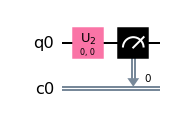

In [3]:
# Código para caracterizar el error de amplitud en un solo qubit

qubits = [0] 

######################
# ampcal_1Q_circuits #
######################
circuits , ndata = ampcal_1Q_circuits(10,qubits)

# Imprimimos los primeros tres circuitos para observar la diferencia entre ellos

circuits[0].draw(output = "mpl")


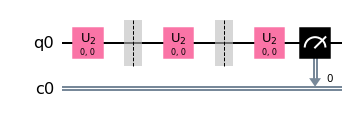

In [4]:
circuits[1].draw(output = "mpl")

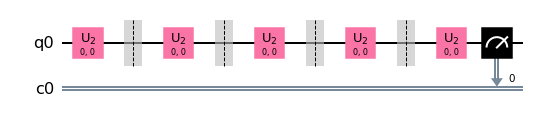

In [5]:
circuits[2].draw(output = "mpl")

En los circuitos vemos las compuertas $U_2(0,0)$, las cuales corresponden a pulsos $Y90$. Las compuertas $U_2(-\pi/2,\pi/2)$, que aparecerán después en este notebook corresponden a pulsos $X90$.

In [6]:
# Ejecutamos nuestros circuitos en el backend de preferencia
# En este caso el backend es el simulador con el modelo de ruido predefinido para la amplitud

backend = qiskit.Aer.get_backend('qasm_simulator')

ampcal_1Q_result = qiskit.execute(circuits, backend,
                                shots=1000, noise_model=oneQ_amp_error,    #Aquí entra el modelo de ruido!
                                  optimization_level = 0).result() 


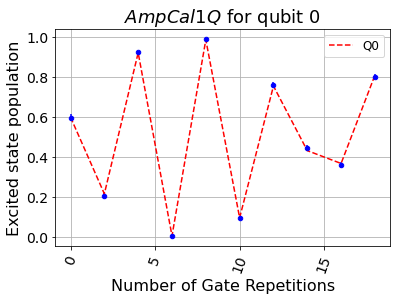

El error de amplitud en nuestro qubit es de : 0.100225 radianes


In [7]:
# Parámetros iniciales para el ajuste mediante AmpCalFitter, modifícalos y observa que pasa
initial_theta = 0.02
initial_c = 0.5


################
# AmpCalFitter #
################

amp_fit = AmpCalFitter(ampcal_1Q_result, ndata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

# Gráfica de los datos de población excitada como función del número de repeticiones
amp_fit.plot(0)

plt.show()
print("El error de amplitud en nuestro qubit es de : %f radianes"%(amp_fit.angle_err()[0]))

Si observamos, al diagnosticar el error de amplitud obtuvimos un valor de $d\theta$ cercano al error diseñado en el modelo de ruido con $d\theta_T = 0.1$. __¿Cómo se podría hacer más exacta esta estimación?__

<a id="secc1.3"></a>
## Error de ángulo

El error de ángulo considera el caso opuesto al error de amplitud, en este se tiene una rotación por un ángulo bien definido, pero ahora el eje de rotación no está bien definido. El eje de rotación se considera en algún lugar entre el eje X y el eje Y. Matemáticamente este error se ve de la siguiente forma, asumiendo un ángulo definido de $\theta = \pi/2$:

$$ Y90_{E} = \exp{
[-i\pi/4(\cos(d\phi)\sigma_Y + \sin(d\phi)\sigma_X)]}$$

Notemos que si este error es nulo, es decir $d\phi = 0$, entonces $\sin(d\phi) = 1, \cos(d\phi) = 0$ y la rotación es la deseada. 

De manera análoga al error de amplitud, este error debe ser amplificado para poder ser determinado. Esto se hace utilizando una secuencia de compuertas

$$X90 -- \big[\{Y90\}^2 \{X90\}^2\big]^n --  Y90$$


<a id="secc1.4"></a>
## Caracterizando el error de ángulo en Qiskit

### Función:  `anglecal_1Q_circuits(max_reps, qubits, angleerr )`:
> __¿Qué hace?__: Proporciona los circuitos necesarios para medir $d\phi$. Cada circuito prepara un qubit en el estado $\ket{0}$ y aplica la secuencia $X90 -- \big[\{Y90\}^2 \{X90\}^2\big]^n --  Y90$ repitiendo $n$ veces la parte entre corchetes para amplificar el error.

> __¿Qué argumentos toma?__ 
- `max_reps(int)`: El número de repeticiones del circuito de amplificación de error.
- `qubits(List[int])`: Lista de índices que indica a qué qubits se les medirá $d\phi$.
- `angleerr`: Un valor artificial para el error de ángulo.

<div class="alert alert-block alert-danger">

__Acerca del argumento `angleerr`__: 
Esta función sólo es útil para diagnosticar errores de ángulo generados artificialmente, no aquellos generados por un modelo de ruido externo o ruido real. Para generar y diagnosticar este error es necesario pasar un valor para `angleerr` distinto de cero. 
    
</div>

> __¿Qué devuelve?__: Una tupla con dos objetos: lista de objetos `QuantumCircuit` y una `list`. El primero de ellos es una lista de los circuitos cuánticos de amplificación a ejecutar, el segundo es una lista con los datos de cuantas repeticiones se han llevado a cabo.


### Clase:  `AngleCalFitter(backend_result , xdata, qubits, fit_p0, fit_bounds)`:
>__¿Qué hace?__: Crea un objeto que usa los circuitos generados por la función `anglecal_1Q_circuits()`, hace un ajuste de los datos de población del estado $\ket{1}$ como función del número de repeticiones en el circuito para obtener el valor experimental de $d\phi$.

>__¿Qué parámetros de construcción tiene?__:
- ``backend_result(Result)``: Objeto de la clase `Result` en Qiskit, resultado de correr los circuitos `anglecal_1Q_circuits()` con un _backend_ seleccionado.
- ``xdata(Union[List[float], np.array])``: Lista de número de repeticiones generada al crear los circuitos.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $d\phi$. 
- ``fit_p0(List[float])``: Valores iniciales para las variables de ajuste $d\phi$
- ``fit_bounds(Tuple[List[float],List[float]])``: Cotas para los posibles valores del ajuste. La primera lista indica cotas inferiores para cada variable, la segunda lista indica las cotas superiores.


>__¿Qué construye?__: Construye un objeto que contiene los datos de las variables ajustadas, entre ellos el valor de $d\theta$ para el j-ésimo qubit mediante `angle_fit.angle_err()[j]`. Este objeto incluye un método para graficar los datos de población del estado excitado ``ampcal_fit.plot(0)``.


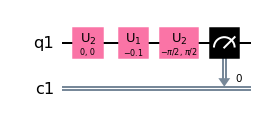

In [8]:
# Código para caracterizar el error de ángulo en un solo qubit

qubits = [0]

########################
# anglecal_1Q_circuits #
########################

# Aquí pasamos al generador de circuitos el error de ángulo artificial a estimar
circuits_angcal, ndata = anglecal_1Q_circuits(10, qubits, angleerr=0.1)

circuits_angcal[0].draw(output = "mpl")

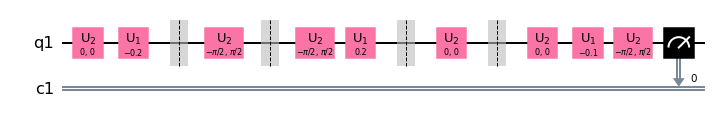

In [9]:
circuits_angcal[1].draw(output = "mpl")

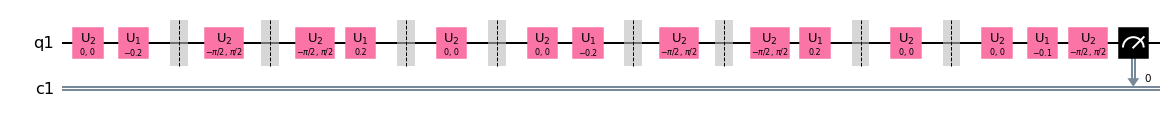

In [10]:
circuits_angcal[2].draw(output = "mpl")


Notemos que la secuencia crece seis compuertas en cada repetición, y que cuando $n=0$ solo se aplican los pulsos $X90$ y $Y90$ y la compuertas que implementa el `angleerr` artificial.

In [11]:
# Guardamos los resultados de correr nuestros circuitos en el backend seleccionado
angcal_1q_res = qiskit.execute(circuits_angcal, backend,
                                shots=1000, 
                               optimization_level = 0).result()     # Observa que no hay modelo de ruido incluido!


Es importante notar que no se usa un modelo de ruido en la ejecución de estos circuitos, ya que el error de ángulo no estima errores generados por modelos de ruido, sino sólo errores artificiales generados _ad hoc_.

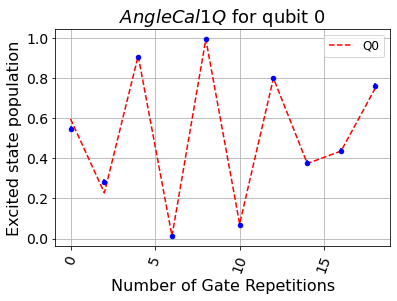

El error de ángulo (artificial) entre los ejes X y Y es de : 0.096192 radianes


In [12]:
# Parámetros iniciales para el ajuste mediante AngleCalFitter, modifícalos y observa que pasa

initial_phi = -0.02 # Intencionalmente lejano al valor que queremos obtener (0.1)
initial_c = 0.5


##################
# AngleCalFitter #
##################
angcal_fit = AngleCalFitter(angcal_1q_res, ndata, qubits,
                   fit_p0=[initial_phi, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

angcal_fit.plot(0)

plt.show()
print("El error de ángulo (artificial) entre los ejes X y Y es de : %f radianes"%(angcal_fit.angle_err()[0]))

<a id="secc2"></a>
# Errores en compuertas de dos qubits

Entre las compuertas de dos qubits, es de particular importancia caracterizar el comportamiento de la compuerta $CX$ ya que esta es utilizada para crear estados entrelazados y forma parte fundamental de muchos algoritmos y protocolos de información cuántica. Estas compuertas también se ven afectadas por los errores de amplitud y ángulo antes explicadas. La diferencia fundamental yace en las secuencias de compuertas que se usan para amplificar el error.

<a id="secc2.1"></a>
## Error de amplitud en compuertas CX

$$CR_X(\pi/2+ d\theta)$$

Para el caso del error de amplitud $CX$ se puede obtener el error de amplitud que resulta de aplicar la compuerta $X$ sobre el qubit objetivo, cuando el qubit de control está en el estado $\ket{1}$. Para esto se deben especificar cuales serán los qubits de control y objetivos, y aplicar la siguiente secuencia de compuertas:

$$X_{(Ctrl)} -- X90_{(Obj)} -- CX^n$$

Se puede entender esta secuencia como una idéntica a aquella para un qubit, agregándo una compuerta que "activa" el qubit de control, y después aplicando compuertas $CX$ sucesivas para amplificar el error.



<a id="secc2.2"></a>
## Caracterizando el error de amplitud CX en Qiskit


### Función:  `ampcal_cx_circuits(max_reps, qubits, controls)`:
> __¿Qué hace?__: Proporciona los circuitos necesarios para medir $d\theta$ en el qubit objetivo. Cada circuito prepara un qubit en el estado $\ket{0}$ y aplica la secuencia $X_{(Ctrl)} -- X90_{(Obj)} -- CX^n$ repitiendo $n$ veces la compuerta $CX$ para amplificar el error.



> __¿Qué argumentos toma?__ 
- `max_reps(int)`: El número de repeticiones del circuito de amplificación de error.
- `qubits(List[int])`: Lista de índices que indica los qubits objetivos a los cuales se les medirá $d\theta$.
- `controls(List[int])`: Lista de índices que indica los qubits que se considerarán como control.

> __¿Qué devuelve?__: Una tupla con dos objetos: lista de objetos `QuantumCircuit` y una `list`. El primero de ellos es una lista de los circuitos cuánticos de amplificación a ejecutar, el segundo es una lista con los datos de cuantas repeticiones se han llevado a cabo.


### Clase:  `AmpCalCXFitter(backend_result , xdata, qubits, fit_p0, fit_bounds)`:
>__¿Qué hace?__: Crea un objeto que usa los circuitos generados por la función `anglecal_cx_circuits()`, hace un ajuste de los datos de población del estado $\ket{1}$ en el qubit seleccionado como objetivo como función del número de repeticiones en el circuito para obtener el valor experimental de $d\theta$.

>__¿Qué parámetros de construcción tiene?__:
- ``backend_result(Result)``: Objeto de la clase `Result` en Qiskit, resultado de correr los circuitos `anglecal_cx_circuits()` con un _backend_ seleccionado.
- ``xdata(Union[List[float], np.array])``: Lista de número de repeticiones generada al crear los circuitos.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $d\theta$, los objetivos. 
- ``fit_p0(List[float])``: Valores iniciales para las variables de ajuste $d\theta, c$
- ``fit_bounds(Tuple[List[float],List[float]])``: Cotas para los posibles valores del ajuste. La primera lista indica cotas inferiores para cada variable, la segunda lista indica las cotas superiores.


>__¿Qué construye?__: Construye un objeto que contiene los datos de las variables ajustadas, entre ellos el valor de $d\theta$ para el j-ésimo qubit mediante `amp_cx_fit.angle_err()[j]`. Este objeto incluye un método para graficar los datos de población del estado excitado ``ampcal_fit.plot(0)``.


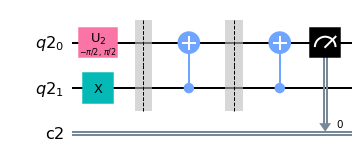

In [13]:
# Ahora es necesario indicar qué qubits se usarán como objetivo y control
qubits = [0]
controls= [1]

######################
# ampcal_cx_circuits #
######################
circuits_CXAmp, ndata_CX = ampcal_cx_circuits(15, qubits, controls)

circuits_CXAmp[2].draw(output = "mpl") # Cambia el número entre corchetes para ver como aumenta la secuencia

In [14]:
# Ejecutamos los circuitos generados 
result_CXAmp = qiskit.execute(circuits_CXAmp, backend, shots = 1000 , noise_model = cx_noise_model,
                             optimization_level = 0).result()

El error de amplitud CX es de: 0.150659 radianes


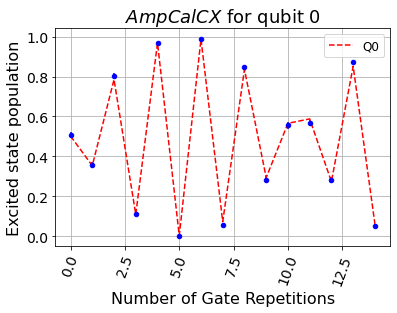

In [15]:
# Parámetros iniciales para el ajuste mediante AngCalCXFitter, hacemos theta lejano al real (0.15)
initial_theta = 0.25
initial_c = 0.04

amp_cx_fit = AmpCalCXFitter(result_CXAmp, ndata_CX, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

amp_cx_fit.plot(0)

print("El error de amplitud CX es de: %f radianes"%(amp_cx_fit.angle_err()[0]))

Obtenemos un valor muy cercano a aquel obtenido en nuestro modelo de ruido predefinido `cx_noise_model`, el cual asignaba un valor para error de amplitud de $d\theta = 0.15$. 

<a id="secc2.3"></a>
## Error de ángulo en compuertas CX

Para este último error se considera la implementación de una compuerta $CR_X$ con un ángulo de rotación bien definido y un eje de rotación desviado.

$$ CR_{\cos(d\theta)\sigma_X + \sin(d\theta)\sigma_Y }(\pi/2)$$

De manera análoga al error de amplitud $CX$, se aplica una secuencia de pulsos/compuertas para amplificar este error, para esto se identifican cuáles serán el qubit de control y el objetivo. La secuencia de amplificación del error es la siguiente:

$$ X_{(Ctrl)} -- Y_{(Obj)} -- [CX -- Y90_{(Obj)}]^n -- X90_{(Obj)}$$ 

<a id="secc2.4"></a>
## Caracterizando el error de ángulo CX en Qiskit


### Función:  `anglecal_cx_circuits(max_reps, qubits, controls, angleerr)`:
> __¿Qué hace?__: Proporciona los circuitos necesarios para medir $d\phi$. Tras identificar los qubits de control y objetivo se aplica la secuencia $ X_{(Ctrl)} -- Y_{(Obj)} -- [CX -- Y90_{(Obj)}]^n -- X90_{(Obj)}$ repitiendo $n$ veces la parte entre corchetes para amplificar el error.


> __¿Qué argumentos toma?__ 
- `max_reps(int)`: El número de repeticiones del circuito de amplificación de error.
- `qubits(List[int])`: Lista de índices representando los qubits objetivos, indica a qué qubits se les medirá $d\phi$.
- `contros(List[int])`: Lista de índices representando los qubits de control.

- `angleerr`: Un valor artificial para el error de ángulo.

<div class="alert alert-block alert-danger">

__Acerca del argumento `angleerr`__: 
Análogamente al caso para un qubit, para generar y diagnosticar este error es necesario pasar un valor para `angleerr` distinto de cero. 
    
</div>

> __¿Qué devuelve?__: Una tupla con dos objetos: lista de objetos `QuantumCircuit` y una `list`. El primero de ellos es una lista de los circuitos cuánticos de amplificación a ejecutar, el segundo es una lista con los datos de cuantas repeticiones se han llevado a cabo.


### Clase:  `AngleCalFitter(backend_result, xdata, qubits, fit_p0, fit_bounds)`:
>__¿Qué hace?__: Crea un objeto que usa los circuitos generados por la función `anglecal_cx_circuits()`, hace un ajuste de los datos de población del estado $\ket{1}$ como función del número de repeticiones en el circuito para obtener el valor experimental de $d\phi$.

>__¿Qué parámetros de construcción tiene?__:
- ``backend_result(Result)``: Objeto de la clase `Result` en Qiskit, resultado de correr los circuitos `anglecal_cx_circuits()` con un _backend_ seleccionado.
- ``xdata(Union[List[float], np.array])``: Lista de número de repeticiones generada al crear los circuitos.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $d\phi$. 
- ``fit_p0(List[float])``: Valores iniciales para las variables de ajuste $d\phi$
- ``fit_bounds(Tuple[List[float],List[float]])``: Cotas para los posibles valores del ajuste. La primera lista indica cotas inferiores para cada variable, la segunda lista indica las cotas superiores.


>__¿Qué construye?__: Construye un objeto que contiene los datos de las variables ajustadas, entre ellos el valor de $d\phi$ para el j-ésimo qubit, accesible mediante `ang_cx_fit.angle_err()[j]`. Este objeto incluye un método para graficar los datos de población del estado excitado `ang_cx_fit.plot(0)`.


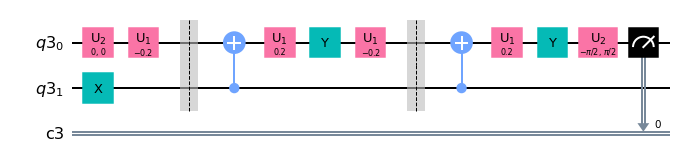

In [16]:
# Código para el error de ángulo en compuertas CX

# Ahora es necesario indicar qué qubits se usarán como objetivo  y control
qubits = [0]
controls= [1]

######################
# ampcal_cx_circuits #
###################### 

# Aquí pasamos al generador de circuitos el error de ángulo artificial a estimar

circuits_CXAng, ndata_CX = anglecal_cx_circuits(15, qubits, controls, angleerr = 0.2)

circuits_CXAng[2].draw(output = "mpl")

In [17]:
# Ejecutamos los circuitos en el backend seleccionado, sin modelo de ruido

result_CXAng = qiskit.execute(circuits_CXAng, backend, shots = 1000, optimization_level = 0).result()

El error de ángulo CX (artificial) para el qubit 0 es de: 0.200391 radianes


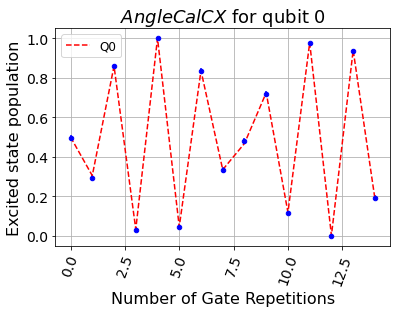

In [18]:
# Parámetros iniciales para el ajuste mediante AngleCalCXFitter hacemos el ángulo distinto del real (0.2)

initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


####################
# AngleCalCXFitter #
#################### 
ang_cx_fit = AngleCalCXFitter(result_CXAng, ndata_CX, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

ang_cx_fit.plot(0)

print("El error de ángulo CX (artificial) para el qubit 0 es de: %f radianes"%(ang_cx_fit.angle_err()[0]))

Nuevamente obtenemos un valor para el error de ángulo considerablemente cercano al valor estipulado de $d\phi =0.2$

__¡Prueba modificando los modelos de ruido y parámetros de ajuste para ver que sucede en cada caso!__

<a id="secc3"></a>
# Referencias
***
- [1] Qiskit Development Team. Hamiltonian and Gate Characterization. Consultado en https://qiskit.org/documentation/tutorials/noise/1_hamiltonian_and_gate_characterization.html
<a id="ref2"></a>
- [2] McKay, D. Gate Errors. Consultado en https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/ignis/gate_errors.ipynb


<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: right;">
            <a href="02_Error_ZZ.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                Notebook siguiente: 02_Error_ZZ >>
            </a>
            </div>
        </td>
    </tr>
</table>